# Solvation shell sampling of Cu(dmp)phos and Cu(phen)phos in ACN, S$_0$ and T$_1$


The scattering calculations are done with my python package [grsq](https://grsq.readthedocs.io/) which you can install via pip, and you should be good to go:

In [ ]:
!pip install grsq

In [77]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import matplotlib, os
from pathlib import Path
import numpy as np
from ase.io import read
from ase import Atoms

%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-3, 3))
plt.rcParams.update({'font.size': 14})

All of the first parts of this cell concerns initializing the simulations, and have already been done, so if you want to mess around with generating S(Q) signals from g(r)s, skip right ahead to the section "Scattering from RDFs"

## Creating the MD systems

The 'correct' way to parametrize a transition metal complex within AMBER/GAFF is described [here](https://ambermd.org/tutorials/advanced/tutorial20/mcpbpy_heme.php). However, that requires a lot of manual work, and is not very 'user-friendly' for people who are not MM MD nerds. _If_ we are going to freeze the solute-structure to the DFT-optimized geometries anyway, there should not be any need to go through all the hurdles of generating [internal FF parameters](https://en.wikipedia.org/wiki/AMBER) (bond lengths- and strengths, angle- and dihedral terms). 

Parametrization of purely organic compounds is [a bit easier](https://ambermd.org/tutorials/basic/tutorial4b/index.php) within GAFF, but still, for 'static' solvation shell sampling, it is still more work than necessary. 

Therefore, I've built `EmptyInside` that generates an "empty" force field parametrizations to sidestep this part of the task entirely. However, it seems like you cannot avoid _all_ bonding information entirely, as the non-bonded interactions need this information to switch off the terms between neighboring atoms. This means that poor automated bonding-guesser codes and/or 'weird' structures can still cause problems. 

The code was written _while_ exploring what's possible and what is not, which impedes the overall design significantly. It should be rewritten from bottom up once the absolute most robust workflow has been found,. 


We should solvate all 4 molecules/charge-sets in Acetonitrile. 

We're getting partial charges from DFT calculations carried out in ORCA, and creating [ASE](https://wiki.fysik.dtu.dk/ase/index.html) `Atoms` objects that `EmptyInside` works with. 

In [166]:
from cmm.md.empty_inside import EmptyInside as EI  
def get_charges(orca_out):
    charges = []
    with open(orca_out, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if 'CHELPG Charges' in line:
            for cline in lines[i + 2:]:
                if '---' in cline:
                    return np.array(charges)
                charges.append(float(cline.split()[-1]))
            
    
out_files = sorted([p for p in Path('DFT/charges/').rglob('*out*')])
all_systems = {'CudmpDPEphos' : {'S0': None, 'T1': None},
               'CuphenDPEphos' : {'S0': None, 'T1': None}}
sys_sizes = {'CudmpDPEphos': None, 'CuphenDPEphos':None}
for of in out_files:
    charges = get_charges(str(of))
    atoms = read(str(of).replace('inp.out', 'xyz'))
    
    atoms.set_initial_charges(charges)
    
    # add counterion 15 Å away from COM, in... some direction.
    v = atoms.positions.max(0) - atoms.get_center_of_mass() 
    v /= np.linalg.norm(v)
    atoms += Atoms('Cl', positions=[15 * v], charges=[-1])
    print(of.parts[2], sum(atoms.get_initial_charges()), len(atoms))

    molname, solvent, state, _ = of.parts[2].split('_')
    all_systems[molname][state] = atoms
    sys_sizes[molname] = len(atoms) 

CudmpDPEphos_ACN_S0_state 1.0000000003618226e-06 97
CudmpDPEphos_ACN_T1_state 8.881784197001252e-16 97
CuphenDPEphos_ACN_S0_state -9.999999970311535e-07 91
CuphenDPEphos_ACN_T1_state -5.999999998285155e-06 91


#### Create dirs with all the solvated systems and necessary files:
If the solvent was water, the OpenMM [Modeller](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.modeller.Modeller.html) class can automatically solvate and add counterions to charge-neutralize the system. 

For custom organic solvents, things get a bit more involved, and we're using `gmx solvate` from Gromacs (yes... another MD program altogether...) with the topologies from https://virtualchemistry.org/

Gromacs will spill out a buncha stuff here. 

In [145]:
root_dir = os.getcwd()
for molname, val in all_systems.items():
    for state, atoms in val.items():
        print('######################################')
        print(molname, state, atoms)
        
        os.chdir(root_dir)
        this_path = f'MD/{molname}_{state}_ACN'
        os.makedirs(this_path, exist_ok=True)
        os.chdir(this_path)
        
        solute = atoms[:-1]
        ct_ions = Atoms([atoms[-1]])
        
        ei = EI(f'{molname}_{state}_ACN')
        ei.add_solute(solute, neutralize=ct_ions)  # add solute atoms
        ei.init_poor_mans_gaff(charges=atoms.get_initial_charges(), solvent=False)  # Solvent param can only be used for water. Should be renamed. 
        ei.add_gmx_solvent(v_top_path=root_dir + '/MD/acn/topol.top',  
                           v_name='acn', 
                           v_gro_path=root_dir + '/MD/acn/conf.gro',
                           boxside_ang=75)  

######################################
CudmpDPEphos S0 Atoms(symbols='C50H40ClCuN2OP2', pbc=False, initial_charges=...)
Note that major changes are planned in future for editconf, to improve usability and utility.
Read 6 atoms
Volume: 64 nm^3, corresponds to roughly 28800 electrons
No velocities found
    system size :  0.171  0.171  0.298 (nm)
    center      :  2.000  2.000  2.001 (nm)
    box vectors :  4.000  4.000  4.000 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  64.00               (nm^3)
    shift       : -1.814 -1.815 -1.752 (nm)
new center      :  0.186  0.186  0.249 (nm)
new box vectors :  0.371  0.371  0.498 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :   0.07               (nm^3)

If the molecule rotates the actual distance will be smaller. You might want
to use a cubic box instead, or why not try a dodecahedron today?

GMX says (stderr):                      :-) GROMACS - gmx editconf, 2023.3 (-:

Executable:   /usr/l

#### Create CMMSystems runscripts for all 4 systems

With the `gmx solvate`-based systems, it turned out to be easiest just to load in the gmx-formatted topology- and positions-file into my old `CMMSystem` class, which is basically just a "convenience-API" to the already existing OpenMM python API that sometimes get a bit... long-winded.. 

I haven't gotten around to properly integrate `EmptyInside` and `CMMSystems` (which needs a BIG cleanup anyways to be honest) such that both are sub classes of some base class that has the methods that are currently just hard-copied from CMMSystems to EmptyInside (and then only used when the solvent is water.. yeah.. somewhat messy currently.. apologies)

In [165]:
def get_runscript(molname, state, sys_size):
    runscript = f'''\
import os
from sys import stdout
from cmm.md.cmmsystems import CMMSystem
from openmm import unit, app
from openmm import openmm as mm

sys = CMMSystem(tag='{molname}_{state}_ACN_npt', fpath=os.getcwd())
sys.system_from_gromacs('system.top',
                        '{molname}_{state}_ACN_acn.gro')

sys.restrain_atoms(list(range({sys_size - 1})))
sys.flat_bottom_repulsive([0], [{sys_size}], r0=15 * unit.angstrom, k=1000)
sys.add_barostat()
sys.set_integrator()
sys.init_simulation()

# minimize
sys.minimize(maxIterations=1000)

# reporters
sys.standard_reporters()

# run NPT eq
sys.run(time_in_ns=2)


#### run NVT production
sys = CMMSystem(tag='{molname}_{state}_ACN_nvt', fpath=os.getcwd())
sys.system_from_gromacs('system.top',
                        '{molname}_{state}_ACN_acn.gro')

sys.load_rst7('{molname}_{state}_ACN_npt.rst7')

sys.restrain_atoms(list(range({sys_size - 1})))
sys.flat_bottom_repulsive([0], [{sys_size}], r0=15 * unit.angstrom, k=1000)
sys.set_integrator()
sys.init_simulation()
sys.standard_reporters()

# run NVT eq
sys.run(time_in_ns=6)

'''
    return runscript

In [166]:
for molname, val in all_systems.items():
    for state, atoms in val.items():
        print('######################################')
        os.chdir(root_dir)
        this_path = f'MD/{molname}_{state}_ACN'
        os.chdir(this_path)
        runscript = get_runscript(molname, state, sys_sizes[molname]) 

        with open(f'{molname}_{state}_ACN.py', 'w') as f:
            f.write(runscript)

######################################
######################################
######################################
######################################


All four simulations where run on the HPC, and the results transfered back

# Scattering from RDFs
Using `grsq`.  `!pip install grsq`. 



In [81]:
import parmed as pmd
import re, itertools
from grsq.grsq import RDFSet, RDF
from grsq.damping import Damping
from grsq.debye import Debye

The resname for the molecule is 'mol', and for the solvent is 'MOL'.   
So let's get the stoichometry of atom types from the gro. Ignore the counterion.

Loading the RDFs, getting number of each atom type from .gro files. Checking that we have all that we need.

In [84]:
def load_rdfs(grofile, datpath, volume, solute_resname='mol', solvent_resname='MOL'): 
    ''' Creates RDFSet from a gro file and all .dat files in datpath
    '''

    gro = pmd.load_file(grofile)

    u = [atom.name for atom in gro.atoms if atom.residue.name == solute_resname]
    u_stoich = {element: u.count(element) for element in set(u)}
    v = [re.sub(r'\d+', '', atom.name) for atom in gro.atoms if atom.residue.name == solvent_resname] # remove numbers
    v_stoich = {element: v.count(element) for element in set(v)}
    
    stoich = {}
    # Add entriesw ith "_u" or "_v" appended to the keys
    stoich.update({key + '_u': value for key, value in u_stoich.items()})
    stoich.update({key + '_v': value for key, value in v_stoich.items()})

    dats = sorted([p for p in Path(datpath).rglob('*dat')])
    dats = [dat.name for dat in dats]

    where = {'u':'solute', 'v':'solvent'}
    rdfs = RDFSet()
    for l, n_l in stoich.items():
        for m, n_m in stoich.items():
            if (l == m) and n_l == 1:
                continue
            l_el, l_w = l.split('_')
            m_el, m_w = m.split('_')
    
            dat = f'g{l}-{m}.dat'
            data = np.genfromtxt(f'{datpath}/{dat}')
            dats.remove(dat)
            r = data[:, 0]
            g = data[:, 1]
            
            rdf = RDF(r=r, g=g, name1=l_el, name2=m_el,
                      region1=where[l_w], region2=where[m_w],
                      n1=n_l, n2=n_m,
                      volume=volume)
            rdfs.add_rdf(rdf)
    
    if len(dats) > 0:
        print(f'Leftover dat files: {dats}')
    print(stoich)
    return rdfs

In [85]:
grofile = 'MD/CudmpDPEphos_S0_ACN/CudmpDPEphos_S0_ACN_acn.gro'
datpath = 'MD/CudmpDPEphos_S0_ACN/'
rdfs_dmp_s0 = load_rdfs(grofile, datpath, volume=524.2620439465109 * 1e3)  # i get the volumes from the log files
rdfs_dmp_s0.vdv_correct()  # finite size correction

grofile = 'MD/CudmpDPEphos_T1_ACN/CudmpDPEphos_T1_ACN_acn.gro'
datpath = 'MD/CudmpDPEphos_T1_ACN/'
rdfs_dmp_t1 = load_rdfs(grofile, datpath, volume=524.0954625802389 * 1e3)
rdfs_dmp_t1.vdv_correct() # finite size correction


{'N_u': 2, 'H_u': 40, 'Cu_u': 1, 'C_u': 50, 'O_u': 1, 'P_u': 2, 'C_v': 11942, 'N_v': 5971, 'H_v': 17913}
{'N_u': 2, 'H_u': 40, 'Cu_u': 1, 'C_u': 50, 'O_u': 1, 'P_u': 2, 'C_v': 11940, 'N_v': 5970, 'H_v': 17910}


We can check the contents of the `RDFSet`s:

In [86]:
rdfs_dmp_s0.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | N-solute--N-solute      | N1:     2, N2:     2 | solute , solute  | 524262.0439 |
| 001 | N-solute--H-solute      | N1:     2, N2:    40 | solute , solute  | 524262.0439 |
| 002 | N-solute--Cu-solute     | N1:     2, N2:     1 | solute , solute  | 524262.0439 |
| 003 | N-solute--C-solute      | N1:     2, N2:    50 | solute , solute  | 524262.0439 |
| 004 | N-solute--O-solute      | N1:     2, N2:     1 | solute , solute  | 524262.0439 |
| 005 | N-solute--P-solute      | N1:     2, N2:     2 | solute , solute  | 524262.0439 |
| 006 | N-solute--C-solvent     | N1:     2, N2: 11942 | solute , solvent | 524262.0439 |
| 007 | N-solute--N-solvent     | N1:     2, N2:  5971 | solute , solvent | 524262.0439 |
| 008 | N-solute--H-solvent     | N1:     2, N2: 17913 | solute , solvent | 524262.0439 |
| 009 | H-solute--N-solute      | N1:    40, N2:     2 | solute , solute  | 524262.0439 |
| 010 | H-solute

In [87]:
atoms = read('DFT/initial_xyzs/CudmpDPEphos_ACN_S0_state.xyz')
for sym in np.unique(atoms.get_chemical_symbols()):
    print(sym, len([atom for atom in atoms if atom.symbol == sym]))

C 50
Cu 1
H 40
N 2
O 1
P 2


Looks correct. Plot some rdfs to check for any suprises

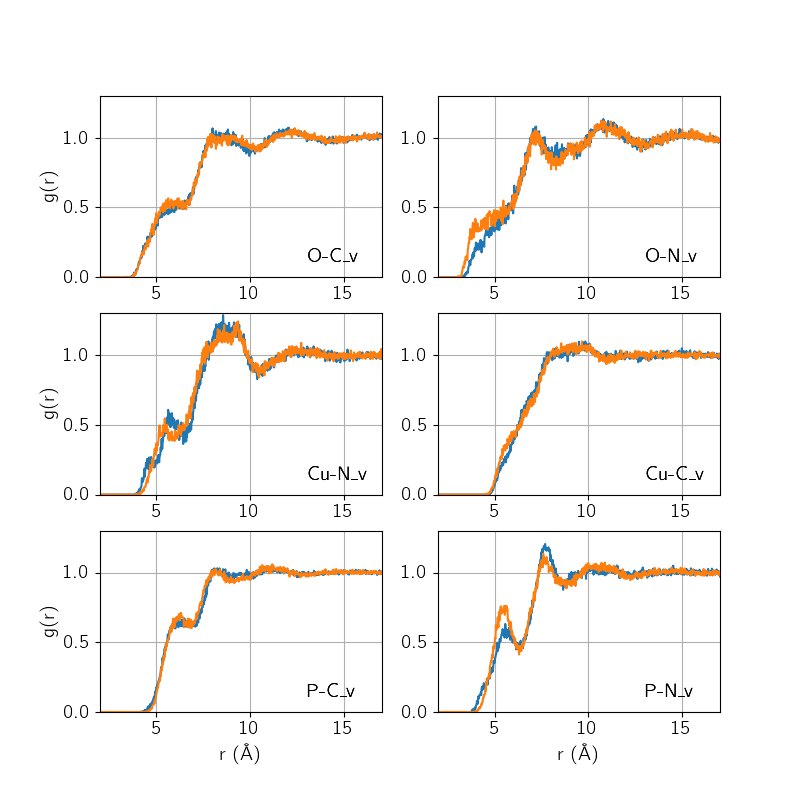

In [92]:
idxs = [40, 41, 24, 23, 49, 50]
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
for i, idx in enumerate(idxs):
    ax = axes.ravel()[i]
    for rdfs in (rdfs_dmp_s0, rdfs_dmp_t1):
        rdf = rdfs[idx]
        pair = f'{rdf.name1}-{rdf.name2}_v'
        ax.plot(rdf.r, rdf.g)
        ax.text(13, 0.1, pair)

for ax in axes.ravel():
    ax.set_xlim([2, 17])
    ax.set_ylim([0, 1.3])
    ax.grid()

for ax in axes[2, :]:
    ax.set_xlabel('r (Å)')
for ax in axes[:, 0]:
    ax.set_ylabel('g(r)')

Nothing seems out of the ordinary, let's calculate some scattering

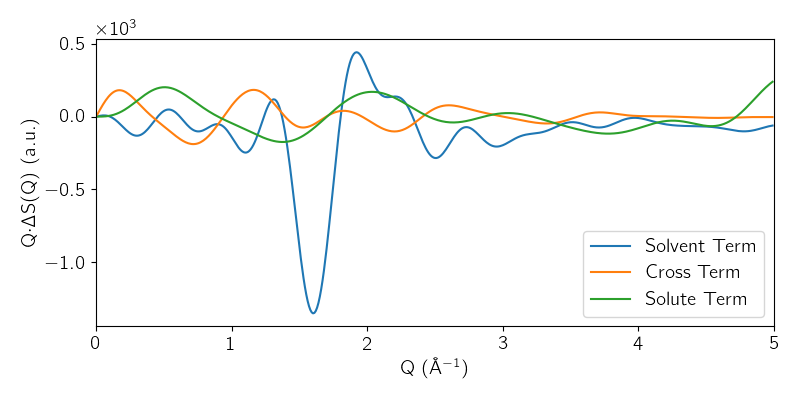

In [123]:
from grsq.damping import Damping

#damp = Damping('lorch', L=rdfs_dmp_t1[0].r[-1])  # didn't seem to get rid of all truncation artefacts
damp = Damping('zederkof', r_cut=15, r_max=17)
qvec = np.arange(0, 5, 0.01)


su_dmp_s0 = rdfs_dmp_s0.get_solute(qvec)
su_dmp_t1 = rdfs_dmp_t1.get_solute(qvec)


sc_dmp_s0 = rdfs_dmp_s0.get_cross(qvec, damping=damp)
sc_dmp_t1 = rdfs_dmp_t1.get_cross(qvec, damping=damp)

sv_dmp_s0 = rdfs_dmp_s0.get_solvent(qvec, damping=damp)
sv_dmp_t1 = rdfs_dmp_t1.get_solvent(qvec, damping=damp)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, (sv_dmp_t1 - sv_dmp_s0) * qvec, label='Solvent Term')
ax.plot(qvec, (sc_dmp_t1 - sc_dmp_s0) * qvec, label='Cross Term')
ax.plot(qvec, (su_dmp_t1 - su_dmp_s0) * qvec, label='Solute Term')


ax.legend(loc='lower right')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q$\cdot \Delta$S(Q) (a.u.)')
ax.set_xlim([0, 5])
fig.tight_layout()

### CuphenDPEphos

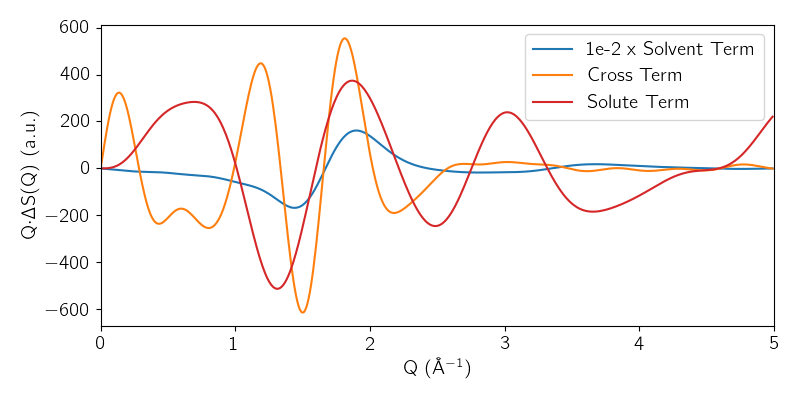

In [105]:
grofile = 'MD/CuphenDPEphos_S0_ACN/CuphenDPEphos_S0_ACN_acn.gro'
datpath = 'MD/CuphenDPEphos_S0_ACN/'
rdfs_phen_s0 = load_rdfs(grofile, datpath, volume=523.103014055799 * 1e3)
rdfs_phen_s0.vdv_correct()  # finite size correction

grofile = 'MD/CuphenDPEphos_T1_ACN/CuphenDPEphos_T1_ACN_acn.gro'
datpath = 'MD/CuphenDPEphos_T1_ACN/'
rdfs_phen_t1 = load_rdfs(grofile, datpath, volume=519.8675928579494 * 1e3)
rdfs_phen_t1.vdv_correct() # finite size correction

damp = Damping('zederkof', r_cut=15, r_max=17)
qvec = np.arange(0, 5, 0.01)

atoms_s0 = read('DFT/initial_xyzs/CuphenDPEphos_ACN_S0_state.xyz')
atoms_t1 = read('DFT/initial_xyzs/CuphenDPEphos_ACN_T1_state.xyz')

deb = Debye(qvec=qvec)

su_phen_s0 = deb.debye(atoms_s0)
su_phen_t1 = deb.debye(atoms_t1)

sc_phen_s0 = rdfs_phen_s0.get_cross(qvec, damping=damp)
sc_phen_t1 = rdfs_phen_t1.get_cross(qvec, damping=damp)

sv_phen_s0 = rdfs_phen_s0.get_solvent(qvec, damping=damp)
sv_phen_t1 = rdfs_phen_t1.get_solvent(qvec, damping=damp)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(qvec, (sv_phen_t1 - sv_phen_s0) * qvec * 1e-2, label='1e-2 x Solvent Term')
ax.plot(qvec, (sc_phen_t1 - sc_phen_s0) * qvec, label='Cross Term')
ax.plot(qvec, (su_phen_t1 - su_phen_s0) * qvec, 'C3', label='Solute Term')

ax.legend(loc='best')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q$\cdot \Delta$S(Q) (a.u.)')
ax.set_xlim([0, 5])
fig.tight_layout()


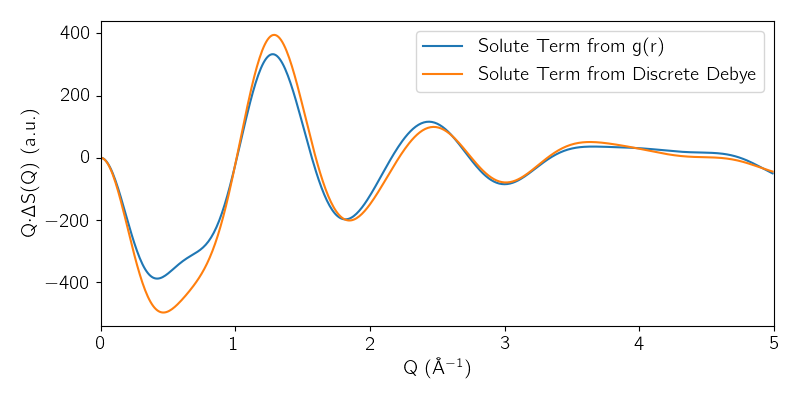

In [106]:
su_phen_s0_deb = deb.debye(atoms_s0)
su_phen_t1_deb = deb.debye(atoms_t1)

su_phen_s0_gr = rdfs_phen_s0.get_solute(qvec)
su_phen_t1_gr = rdfs_phen_t1.get_solute(qvec)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, (su_phen_s0_gr - su_phen_t1_gr) , 'C0', label='Solute Term from g(r)')
ax.plot(qvec, (su_phen_s0_deb - su_phen_t1_deb) , 'C1', label='Solute Term from Discrete Debye')
ax.legend(loc='best')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('Q$\cdot \Delta$S(Q) (a.u.)')
ax.set_xlim([0, 5])
fig.tight_layout()

The discrete and general debye formulation gives the same scattering for when $g(r) \rightarrow \delta (r - r_{ij})$

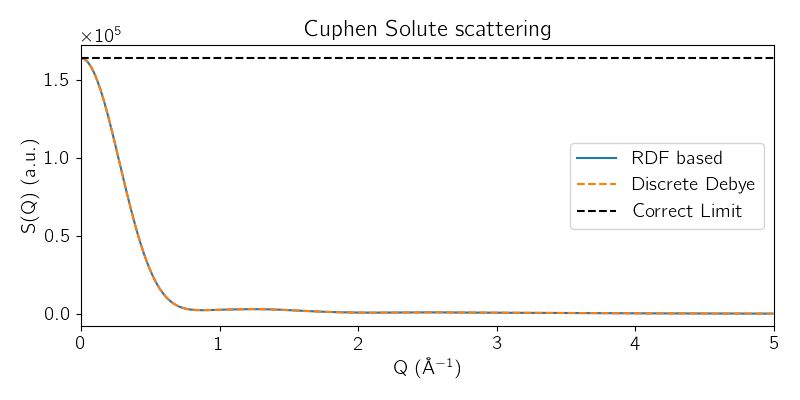

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(qvec, su_phen_s0_gr, 'C0-', label='RDF based')
ax.plot(qvec, su_phen_s0_deb, 'C1--', label='Discrete Debye')

ax.axhline(sum([atom.number for atom in atoms_s0])**2, color='k', linestyle='--', label='Correct Limit')
ax.set_title('Cuphen Solute scattering')
ax.legend(loc='best')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.set_ylabel('S(Q) (a.u.)')
ax.set_xlim([0, 5])
fig.tight_layout()


And the absolute scattering goes to the correct $q=0$ limit, (#electrons)$^2$

### Some comments


#### How I did the MD-Sampling: some room for improvement based on feedback:
Both S0 and T1 were NPT equilibrated, before sampling in NVT for 5 ns. That may or not be what you want, depending on the time scales you are studying. It assumes that the system has had time to re-equilibrate it's density after any changes to the overall extension of the solute. And for this first run, I did not do anything specific to select a box size representative of the average density in the NPT run, the production NVT runs were simply started at the end of the NPT runs. Some room for improvement there. 

Notice how much the volume (density) changed from S0 to T1 in the CuphenDPEphos case. Densities: T1: 0.7865 g/ml, 0.7808 g/ml ... 

#### Damping parameters:
I have not done a very good analysis of my choice of damping method and parameters, it seems like we need rather heavy damping to eliminate truncation artefacts in the fourier transformation of g(r) to S(Q). This could improve with improved MD sampling statistics, and a more systematic analysis (e.g. like in figures 7 & 8 in 10.1063/5.0164365). But maybe it's overkill...


#### The model 
For this version, I simply calculated the CHELPG charges on the geometries provided (`! B3LYP D4 SlowConv CPCM(Acetonitrile) def2-TZVP CHELPG(LARGE)` see `./DFT/charges` for details.  
I've also done geometry optimizations with D4 which did seem to change the structures somewhat, and one could consider comparing the charges (and structures) from these results. 




Save the current results for non-python users

In [110]:
import pandas as pd
header_list = ["Q (Å-1)", "DMP S_v S0", "DMP S_v T1", "DMP S_c S0", "DMP S_c T1",
               "PHEN S_v S0", "PHEN S_v T1", "PHEN S_c S0", "PHEN S_v T1"]

out_data = np.vstack((qvec, sv_dmp_s0, sv_dmp_t1, sc_dmp_s0, sc_dmp_t1, 
                 sv_phen_s0, sv_phen_t1, sc_phen_s0, sc_phen_t1)).T

df = pd.DataFrame(out_data, columns=header_list)

def float_format(x):
    return f"{x:27.16f}"

formatted_str = df.to_string(index=False, float_format=float_format)

with open('cu_xss.dat', 'w') as file:
    file.write('Go to https://gitlab.com/asod/cu_complexes_md to see how this data was generated\n')
    file.write(formatted_str)
!head cu_xss.dat

Go to https://gitlab.com/asod/cu_complexes_md to see how this data was generated
                    Q (Å-1)                  DMP S_v S0                  DMP S_v T1                  DMP S_c S0                  DMP S_c T1                 PHEN S_v S0                 PHEN S_v T1                 PHEN S_c S0                 PHEN S_v T1
         0.0000000000000000     114679.6984016378701199     114907.3271954173105769    -215009.9140198553504888    -213281.2614757139526773     110634.8171886073978385     105309.2887814677669667    -202559.2916398869710974    -198775.4403581930091605
         0.0100000000000000     114788.2327733895654092     115013.4102642818324966    -214849.9404131238698028    -213124.0780697056907229     110739.0759173393598758     105411.4947588996728882    -202401.7936551870661788    -198626.7794236671179533
         0.0200000000000000     115111.5954830672126263     115329.4545605498860823    -214370.6512856757908594    -212653.1351538065064233     111049.708154039588